In [97]:
from transformers import pipeline
import mysql.connector
import pandas as pd
from tqdm import tqdm
import nltk
import pickle
import matplotlib.pyplot as plt

from config import *


In [3]:
classifier = pipeline("text-classification",
                      model='bhadresh-savani/distilbert-base-uncased-emotion', top_k=None, truncation = True)


In [4]:
reddit_db = mysql.connector.connect(
    host=HOST, user=USER, password=PASSWORD, database=DATABASE_NAME
)

cursor = reddit_db.cursor()


In [5]:
cursor.execute("select * from comments")
comments = cursor.fetchall()
comments = pd.DataFrame(
    comments, columns=["id", "comment_body", "post_id",
                       "comment_timestamp", "parent_comment"]
).drop(columns=["comment_timestamp"])


In [6]:
cursor.execute("select * from posts")
posts = cursor.fetchall()
posts = pd.DataFrame(
    posts, columns=["post_id", "post_title",
                    "post_body", "subreddit_name", "timestamp"]
).drop(columns=["timestamp"])


In [38]:
sentiment = dict()

for i, post in tqdm(posts.iterrows(), total=len(posts)):
    sentiment[post.post_id] = classifier(post.post_body)[0]

100%|██████████| 55576/55576 [1:56:10<00:00,  7.97it/s]  


100%|██████████| 55576/55576 [00:00<00:00, 540441.39it/s]


<BarContainer object of 6 artists>

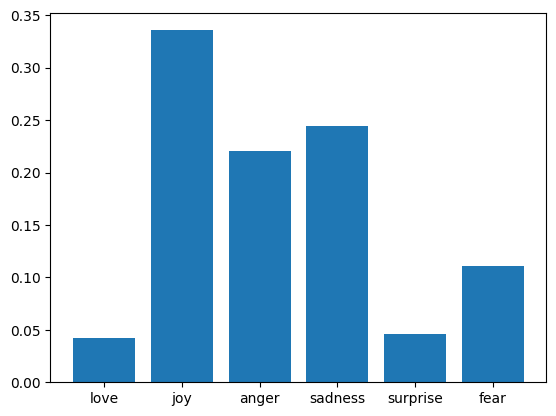

In [105]:
emotions_sum = dict({"love": 0, "joy": 0, "anger": 0, "sadness": 0, "surprise": 0, "fear": 0})

for eval in tqdm(list(sentiment.values())):
    for emotion in eval:
        emotions_sum[emotion["label"]] += emotion["score"]

emotions_avg = {k : emotions_sum[k]/len(posts) for k in emotions_sum}
plt.bar(emotions_avg.keys(), emotions_avg.values())